# Imports

In [1]:
%load_ext autoreload
%autoreload all
import os
import pandas as pd
import numpy as np
import anndata
import time
import json
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import matplotlib.patches as mpatches
from tqdm.notebook import tqdm
import matplotlib.colors as plt_colors
from allensdk.core.reference_space_cache import ReferenceSpaceCache
from pathlib import Path
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors
from Utils.Settings import output_folder_calculations, order_division, order_broad_division, class_to_division, class_to_broad_division, htr_families, neuron_cluster_groups_order, manifest, download_base, output_folder
from Utils.Utils import broad_division_color_map, htr_cmap_rgb, cluster_groups_cmap, htr_cmap, percentage_non_zero
import matplotlib.colors as mcolors
from scipy.signal import find_peaks


# Load data

In [2]:
metadata = manifest['file_listing']['WMB-10X']['metadata']

In [3]:
rpath = metadata['cell_metadata_with_cluster_annotation']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath )
cell = pd.read_csv(file, keep_default_na=False)
cell.set_index('cell_label',inplace=True)

In [4]:
matrices = cell.groupby(['dataset_label','feature_matrix_label'])[['library_label']].count()
matrices.columns  = ['cell_count']


In [5]:
rpath = metadata['example_genes_all_cells_expression']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
exp = pd.read_csv(file)
exp.set_index('cell_label',inplace=True)
exp = exp.sort_index(axis=1)


# Process

In [6]:
cell["division"] = cell['class'].map(class_to_division)
cell["broad_division"] = cell['class'].map(class_to_broad_division)

In [7]:
metadata = manifest['file_listing']['WMB-neighborhoods']['metadata']
rpath = metadata['cluster_group_membership']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
group_membership = pd.read_csv(file) # cluster can belong to two different groups


In [8]:
cell_with_membership = cell.reset_index().merge(group_membership[["cluster_group_label", "cluster_alias", "cluster_group_name"]], on='cluster_alias').set_index("cell_label")


In [9]:
cell_with_membership["cluster_group_color"] = cell_with_membership["cluster_group_name"].map(cluster_groups_cmap)
cell['broad_division_color'] = cell['broad_division'].map(broad_division_color_map)

In [10]:
htrgenes = exp.columns.sort_values()

joined = cell.join(exp)
joined_boolean =  cell.join( exp.astype("bool") )
subsampled = joined.loc[::30]

In [11]:
joined_with_membership = cell_with_membership.join(exp)

joined_boolean_with_membership =  cell_with_membership.join( exp.astype("bool") )
subsampled_with_membership = joined_with_membership.loc[::30]

In [12]:
classification_cmap = joined.drop_duplicates(subset='subclass').set_index('subclass')['subclass_color'].to_dict()
classification_cmap.update(joined.drop_duplicates(subset='supertype').set_index('supertype')['subclass_color'].to_dict())
classification_cmap.update(joined.drop_duplicates(subset='cluster').set_index('cluster')['subclass_color'].to_dict())
classification_cmap.update(joined.drop_duplicates(subset='class').set_index('class')['class_color'].to_dict())


# Load data

In [13]:
datasets = ['Zhuang-ABCA-1','Zhuang-ABCA-2','Zhuang-ABCA-3','Zhuang-ABCA-4']

metadata = {}
for d in datasets :
    metadata[d] = manifest['file_listing'][d]['metadata']

In [14]:
cell = {}

for d in datasets :
    
    rpath = metadata[d]['cell_metadata']['files']['csv']['relative_path']
    file = os.path.join( download_base, rpath)
    cell[d] = pd.read_csv(file, dtype={"cell_label":str})
    cell[d].set_index('cell_label',inplace=True)
    
    sdf = cell[d].groupby('brain_section_label')
    
    print(d,":","Number of cells = ", len(cell[d]), ", ", "Number of sections =", len(sdf))

Zhuang-ABCA-1 : Number of cells =  2846908 ,  Number of sections = 147
Zhuang-ABCA-2 : Number of cells =  1227408 ,  Number of sections = 66
Zhuang-ABCA-3 : Number of cells =  1585843 ,  Number of sections = 23
Zhuang-ABCA-4 : Number of cells =  162578 ,  Number of sections = 3


### Cluster annotation

Read in the pivot table from the "cluster annotation tutorial" to associate each cell with terms at each cell type classification level and the corresponding color.

In [15]:
taxonomy_metadata = manifest['file_listing']['WMB-taxonomy']['metadata']

rpath = taxonomy_metadata['cluster_to_cluster_annotation_membership_pivoted']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
cluster_details = pd.read_csv(file,keep_default_na=False)
cluster_details.set_index('cluster_alias', inplace=True)

rpath = taxonomy_metadata['cluster_to_cluster_annotation_membership_color']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
cluster_colors = pd.read_csv(file)
cluster_colors.set_index('cluster_alias', inplace=True)

In [16]:
cell_extended = {}

for d in datasets :
    cell_extended[d] = cell[d].join(cluster_details,on='cluster_alias')
    cell_extended[d] = cell_extended[d].join(cluster_colors,on='cluster_alias')

For convenience, we can cache this view for later reuse.

### Gene panel

All 4 datasets shares the same 1122 gene panel selected to enable faciliate the mapping to transcriptomically defined cell types taxonomies. Each gene is uniquely identifier by an Ensembl ID. It is best practice to gene identifier to for tracking and data interchange as gene symbols are not unique and can change over time.

Each row of the gene dataframe has Ensembl gene identifier, a gene symbol and name.

In [17]:
rpath = metadata[datasets[0]]['gene']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
gene = pd.read_csv(file)
gene.set_index('gene_identifier',inplace=True)
print("Number of genes = ", len(gene))


Number of genes =  1122


In [18]:
expression_matrices = {}

for d in datasets :
    expression_matrices[d] = manifest['file_listing'][d]['expression_matrices']

In [19]:
htrgenes =  gene.gene_symbol[ gene.gene_symbol.str.contains("Htr")].values
htrgenes = np.sort(htrgenes)
pred = [x in htrgenes for x in gene.gene_symbol]
gene_filtered = gene[pred]


In [20]:
cell_expression = {}
cell_expression_bool = {}

for d in datasets :
    
    expression_matrices[d]
    rpath = expression_matrices[d][d]['log2']['files']['h5ad']['relative_path']
    file = os.path.join( download_base, rpath)
    
    adata = anndata.read_h5ad(file,backed='r')
    
    start = time.process_time()
    gdata = adata[:,gene_filtered.index].to_df()
    gdata.columns = gene_filtered.gene_symbol
    cell_expression[d] = cell_extended[d].join( gdata )
    cell_expression_bool[d] = cell_extended[d].join( gdata.astype("bool") )
    
    print(d,"-","time taken: ", time.process_time() - start)
    
    adata.file.close()
    del adata


Zhuang-ABCA-1 - time taken:  57.48856985400002
Zhuang-ABCA-2 - time taken:  21.867964750999988
Zhuang-ABCA-3 - time taken:  22.00688728099999
Zhuang-ABCA-4 - time taken:  2.862695527000028


### CCF registration and parcellation annotation

Each brain specimen has been registered to Allen CCFv3 atlas, resulting in an x, y, z coordinates and parcellation_index for each cell. 

In [21]:
ccf_coordinates = {}

for d in datasets :
    
    rpath = manifest['file_listing'][d+'-CCF']['metadata']['ccf_coordinates']['files']['csv']['relative_path']
    file = os.path.join( download_base, rpath)
    ccf_coordinates[d] = pd.read_csv(file)
    ccf_coordinates[d].set_index('cell_label',inplace=True)
    ccf_coordinates[d].rename(columns={'x':'x_ccf','y':'y_ccf','z':'z_ccf'},inplace=True)
    
    cell_expression[d] = cell_expression[d].join(ccf_coordinates[d],how='inner')
    cell_expression_bool[d] = cell_expression_bool[d].join(ccf_coordinates[d],how='inner')

In [22]:
metadata = manifest['file_listing']['Allen-CCF-2020']['metadata']
rpath = metadata['parcellation_to_parcellation_term_membership_acronym']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
parcellation_annotation = pd.read_csv(file)
parcellation_annotation.set_index('parcellation_index',inplace=True)
parcellation_annotation.columns = ['parcellation_%s'% x for x in  parcellation_annotation.columns]

rpath = metadata['parcellation_to_parcellation_term_membership_color']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
parcellation_color = pd.read_csv(file)
parcellation_color.set_index('parcellation_index',inplace=True)
parcellation_color.columns = ['parcellation_%s'% x for x in  parcellation_color.columns]

In [23]:
for d in datasets :
    cell_expression[d] = cell_expression[d].join(parcellation_annotation,on='parcellation_index')
    cell_expression[d] = cell_expression[d].join(parcellation_color,on='parcellation_index')   
    cell_expression_bool[d] = cell_expression_bool[d].join(parcellation_annotation,on='parcellation_index')
    cell_expression_bool[d] = cell_expression_bool[d].join(parcellation_color,on='parcellation_index')   


In [24]:
data_merfish = pd.concat(cell_expression).sort_values(by='brain_section_label')
data_merfish = data_merfish[data_merfish['parcellation_division'] != "unassigned"]

color_dict = data_merfish[[ 'parcellation_division_color','parcellation_division']].drop_duplicates().set_index('parcellation_division').to_dict()['parcellation_division_color']
color_dict.update(data_merfish[[ 'parcellation_structure_color','parcellation_structure']].drop_duplicates().set_index('parcellation_structure').to_dict()['parcellation_structure_color'])

# Htr1a

In [25]:
gene = "Htr1a"


In [26]:
dataset = 'Zhuang-ABCA-1'
data_merfish_cor = cell_expression[dataset].sort_values(by='brain_section_label')
data_merfish_cor = data_merfish_cor[data_merfish_cor['parcellation_division'] != "unassigned"]
# Choose colors for each section

s = data_merfish_cor.groupby('brain_section_label')[gene].apply(percentage_non_zero)

# Find the peaks that are at least x distance apart
peaks, _ = find_peaks(s, distance=10)

# Extract these peak values from the series
peak_values = s.iloc[peaks].nlargest(4).sort_index()

section_colors = {
    peak_values.index[0]: '#042A2B',
    peak_values.index[1]: '#5EB1BF',
    peak_values.index[2]: '#CDEDF6',
    peak_values.index[3]: '#EF7B45'
}



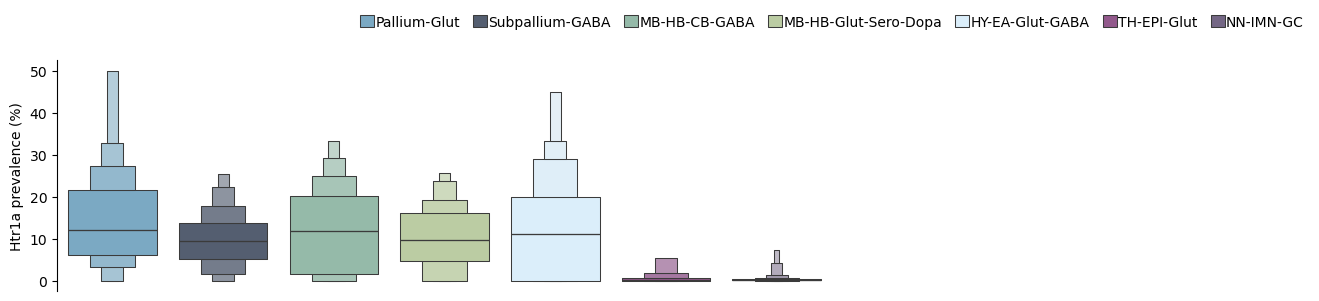

In [27]:
def receptor_prevalence(axs, gene):
    data = joined_with_membership.groupby(["cluster_group_name", 'donor_label'])[gene].apply(percentage_non_zero).reset_index()
    data = data[data["cluster_group_name"]!="WholeBrain"].reset_index(drop=True)
    sns.boxenplot(
    data=data, ax=axs, x="cluster_group_name", y=gene, hue="cluster_group_name", 
    palette=cluster_groups_cmap, order=neuron_cluster_groups_order, hue_order=neuron_cluster_groups_order, showfliers=0, legend=1)

    axs.set_xticks([])  # This will remove the x-axis ticks
    axs.set_xticklabels([])  # This will remove the x-axis labels
    axs.set_xlabel("")  # This will remove the x-axis labels
    sns.despine(ax=axs, bottom=True)
    axs.set_ylabel(f"{gene} prevalence (%)")
    legend = axs.legend(loc='upper center', bbox_to_anchor=(1, 1.25), ncol=len(neuron_cluster_groups_order), frameon=False, 
                       handlelength=1, handleheight=1, handletextpad =.1, columnspacing=.95)
    
fig, axs = plt.subplots(figsize=(10,3))
receptor_prevalence (axs, gene)
    

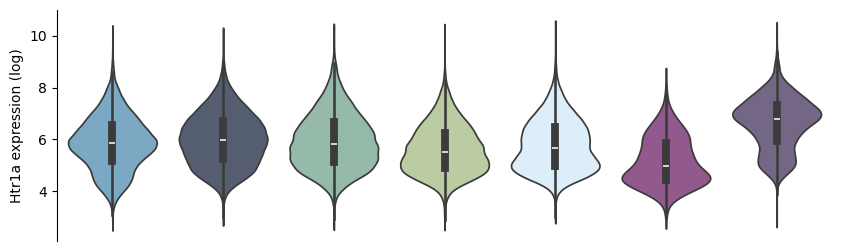

In [28]:
def receptor_expression(axs, gene):
    data = joined_with_membership[(joined_with_membership["cluster_group_name"]!="WholeBrain") & (joined_with_membership[gene]>0)].reset_index(drop=True)
    sns.violinplot(data=data, y=gene,x="cluster_group_name", hue="cluster_group_name" ,ax=axs, palette=cluster_groups_cmap,   order=neuron_cluster_groups_order, hue_order=neuron_cluster_groups_order)
    axs.tick_params(axis='x', rotation=45)
    plt.draw()
    
    for ytick in axs.get_xticklabels():
        ytick.set_color(cluster_groups_cmap[ytick.get_text()])
    sns.despine(ax=axs)
    axs.set_xlabel("")
    axs.set_ylabel(f"{gene} expression (log)")
    sns.despine(ax=axs, bottom=True)
    axs.set_xticks([])
    axs.set_xticklabels([])
fig, axs = plt.subplots(figsize=(10,3))
receptor_expression(axs, gene)

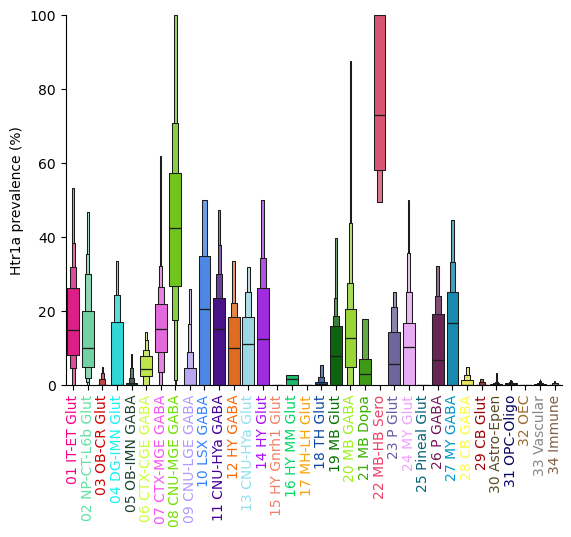

In [29]:
def plot_receptor_transcr_data_per_class(ax, gene):
    sns.boxenplot(
        data=joined.groupby(["class", 'donor_label'])[gene].apply(percentage_non_zero).reset_index(), 
        y=gene, hue="class",x="class", palette=classification_cmap,
        ax=ax, showfliers=0)
    
    plt.draw()
    
    for label in ax.get_xticklabels():
        label.set_rotation(90)
        label.set_color(classification_cmap[label.get_text()])
        #label.set_weight('bold')
    
    ax.set_ylim((0,100))
    ax.set_ylabel(f'{gene} prevalence (%)')
    sns.despine()
    ax.set_xlabel("")
    
fig, ax = plt.subplots()
plot_receptor_transcr_data_per_class(ax, gene)

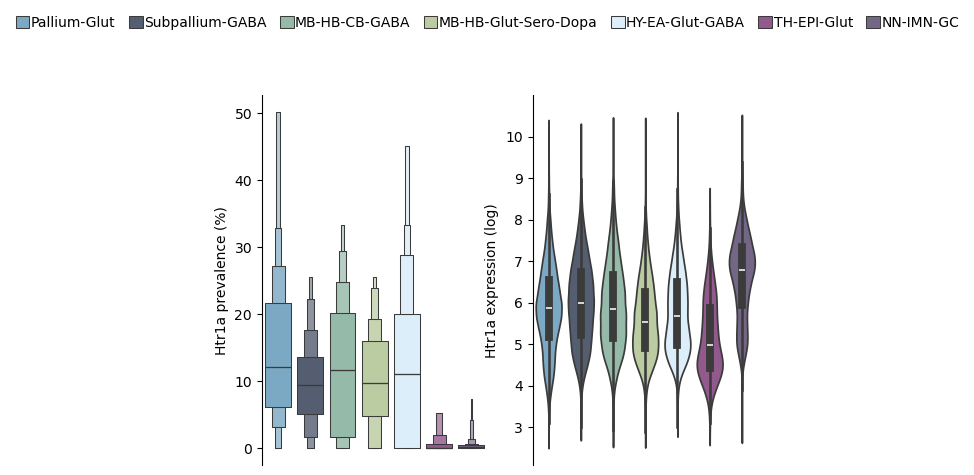

In [30]:
def plot_receptor_transcr_data(axs, gene):
    receptor_prevalence(axs[0], gene)
    receptor_expression(axs[1], gene)
    
fig, axs = plt.subplots(1,2)
plot_receptor_transcr_data(axs, gene)

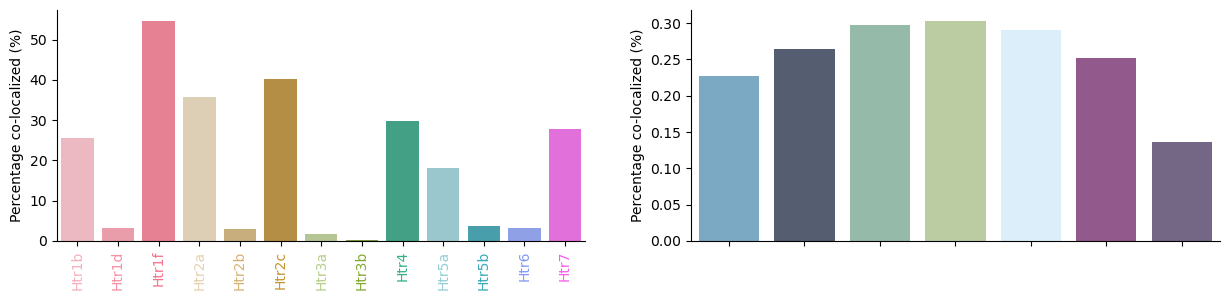

In [31]:
def barplot_coloc(axs, gene):
    coloc = pd.read_pickle(f"{output_folder_calculations}/cluster_group_colocalization.pkl")
    coloc.rename(columns={"Value":"Co-localization"}, inplace=True)
    coloc = coloc[coloc["Gene1"]==gene]

    # Create the line plot
    
    sns.barplot(
        data=coloc.groupby(["group", "Gene1"])["Co-localization"].mean().reset_index(),
        y="Co-localization", x="group",hue="group", palette=cluster_groups_cmap, ax=axs[1], order = neuron_cluster_groups_order
    )
    
    axs[1].set_xlabel("")
    axs[1].set_xticklabels([]) 
    axs[1].set_ylabel("Percentage co-localized (%)")
    
    axs[1].tick_params(axis='x', rotation=90)
    
    
    coloc = pd.read_pickle(f"{output_folder_calculations}/total_colocalization.pkl")
    coloc.rename(columns={"Value":"Co-localization"}, inplace=True)
    
    coloc = coloc[(coloc["Gene1"]==gene) & (coloc["Gene2"]!=gene)]
    sns.barplot(
        data=coloc,
        y="Co-localization", x="Gene2",hue="Gene2", palette=htr_cmap, ax=axs[0]
    )
    axs[0].tick_params(axis='x', rotation=90)
    axs[0].set_xlabel("")
    axs[0].set_ylabel("Percentage co-localized (%)")
    
    plt.draw()
    
    for xtick in axs[0].get_xticklabels():
        xtick.set_color(htr_cmap[xtick.get_text()])
    
        
    sns.despine()

fig, axs = plt.subplots(1,2, figsize=(15,3))
barplot_coloc(axs, gene)

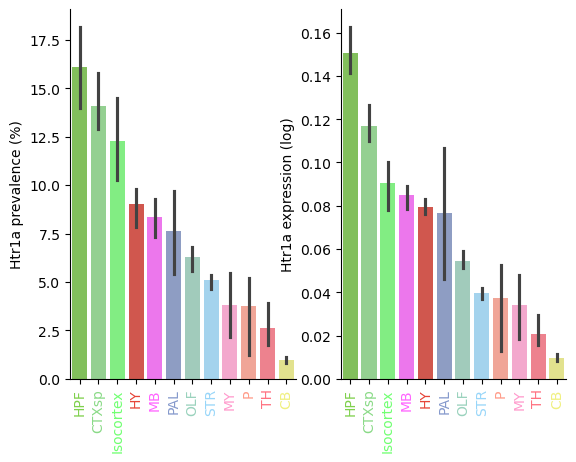

In [32]:
def plot_merfish_expr(axs, gene):
    filtered_data = data_merfish[data_merfish['parcellation_category'] == "grey"].groupby(['parcellation_division', 'feature_matrix_label'])[gene].mean().reset_index()
    sorted_divisions = (filtered_data.groupby('parcellation_division')[gene]
                        .mean()
                        .sort_values(ascending=False)
                        .index)
    
    sns.barplot(data=filtered_data, x='parcellation_division', hue='parcellation_division', y=gene, palette=color_dict, order=sorted_divisions, ax=axs[1] )
    axs[1].tick_params(axis='x', rotation=90)
    axs[1].set_xlabel('')
    axs[1].set_ylabel(f"{gene} expression (log)")
    
    filtered_data = data_merfish[data_merfish['parcellation_category'] == "grey"].groupby(['parcellation_division', 'feature_matrix_label'])[gene].apply(percentage_non_zero).rename(f"{gene} prevalence (%)").reset_index()
    sorted_divisions = (filtered_data.groupby('parcellation_division')[f"{gene} prevalence (%)"]
                        .mean()
                        .sort_values(ascending=False)
                        .index)
    sns.barplot(data=filtered_data, x='parcellation_division', hue='parcellation_division', y=f"{gene} prevalence (%)", palette=color_dict, order=sorted_divisions, ax=axs[0])
    axs[0].tick_params(axis='x', rotation=90)
    axs[0].set_xlabel('')
    sns.despine()
    plt.draw()
    for label in axs[0].get_xticklabels():
        label.set_color(color_dict[label.get_text()])
    for label in axs[1].get_xticklabels():
        label.set_color(color_dict[label.get_text()])
fig, axs = plt.subplots(1,2)
plot_merfish_expr(axs, gene)

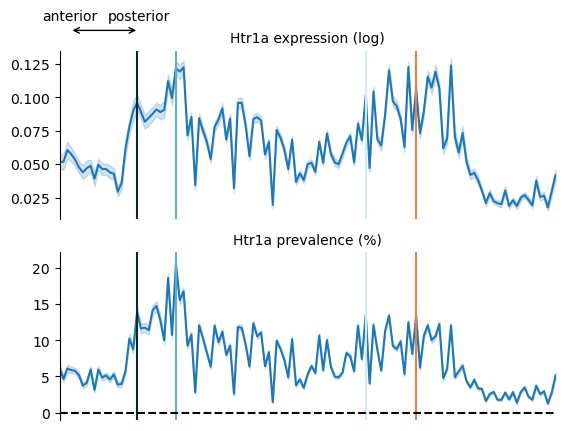

In [33]:
def lineplots_expr_vs_space(axs, section_colors, gene):

    sns.lineplot(data=data_merfish_cor, x='brain_section_label', y=gene, ax=axs[0])
    
    # Add colored vertical lines to the top plot
    for section, color in section_colors.items():
        axs[0].axvline(x=section, color=color)
    sns.despine(ax=axs[0], bottom=True)
    
    sns.lineplot(data=data_merfish_cor, x='brain_section_label', y=gene, ax=axs[1], estimator=percentage_non_zero)
    
    for section, color in section_colors.items():
        axs[1].axvline(x=section, color=color)
    sns.despine(ax=axs[1], bottom=True)
    
    for ax in axs:
        ax.set_xticks([])  # Remove xticks
        ax.set_xticklabels([])  # Remove xticklabels
        ax.set_xlabel("")
        ax.set_xlim([data_merfish_cor['brain_section_label'].min(), data_merfish_cor['brain_section_label'].max()])
        
    axs[0].set_title(f"{gene} expression (log)",  fontsize=10)
    axs[1].set_title(f"{gene} prevalence (%)", fontsize=10)
    axs[0].set_ylabel("")
    axs[1].set_ylabel("")
    axs[1].set_ylabel("")
    axs[1].axhline(y=0,color="k", linestyle='--')


        # Add double-ended horizontal arrow
    axs[0].annotate("anterior", xy=(0.02, 1.18), xycoords='axes fraction', fontsize=10, ha="center")
    axs[0].annotate("posterior", xy=(0.16, 1.18), xycoords='axes fraction', fontsize=10, ha="center")
    axs[0].annotate("", xy=(0.02, 1.12), xycoords='axes fraction', xytext=(0.16, 1.12), textcoords='axes fraction',
                arrowprops=dict(arrowstyle="<->", color='black'))

fig, axs = plt.subplots(2)
lineplots_expr_vs_space(axs, section_colors, gene)

In [34]:
def plot_slice(ax, section, gene):
    ax.scatter(section["x"],section["y"],s=0.5, c=section[gene],marker='.',cmap=sns.color_palette("rocket_r", as_cmap=True))
    ax.scatter(-section["x"]+12,section["y"],s=0.5, c=section['parcellation_structure_color'],marker='.')
    ax.set_ylim(11,0)
    ax.set_xlim(0,11)
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])


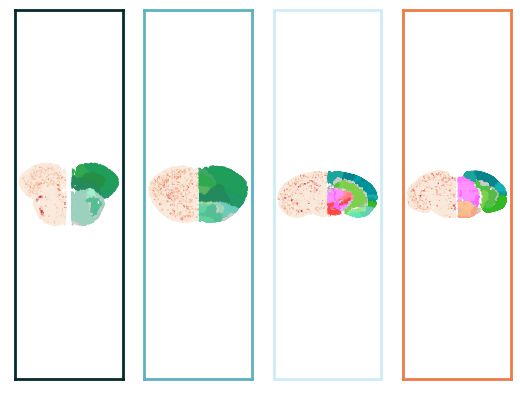

In [35]:
def plot_4_best_sections(axs, section_colors, gene):
    sections = list(section_colors.keys())
    # Below plots
    for i in range(len(section_colors)):
    
        section = data_merfish_cor[data_merfish_cor['brain_section_label'] == sections[i]]
        
        plot_slice(axs[i], section, gene)
        # Set the border color of the subplot
        for spine in axs[i].spines.values():
            spine.set_edgecolor(section_colors[sections[i]])
            spine.set_linewidth(2)  # adjust the width of the border as needed
        
fig, axs = plt.subplots(1,4)

plot_4_best_sections(axs, section_colors, gene)

In [166]:
def plot_figure(gene):
    fig = plt.figure(figsize=(10, 12))
    gs = gridspec.GridSpec(5, 4, height_ratios=[.7,1.5,1,1,1])
    
    subfig = fig.add_subfigure(gs[0,:4])
    axs = subfig.subplots(1,2)
    subfig.suptitle("A", x=-.020, y=1.1, fontsize=16, fontweight='bold');
    subfig.subplots_adjust(wspace=.2, left=.05, bottom=.1, top=.98, right=1)
    plot_receptor_transcr_data(axs, gene)
    subfig.set_facecolor('none')
    
    subfig = fig.add_subfigure(gs[1,:4])
    axs = subfig.subplots()
    subfig.suptitle("B", x=-.02, y=1, fontsize=16, fontweight='bold');
    subfig.subplots_adjust( left=.05, bottom=.5, top=1, right=1)
    plot_receptor_transcr_data_per_class(axs, gene)
    subfig.set_facecolor('none')
    
    if gene in data_merfish_cor.columns:
        ####
        #merfish data
        s = data_merfish_cor.groupby('brain_section_label')[gene].apply(percentage_non_zero)
        
        # Find the peaks that are at least 20 distance apart
        peaks, _ = find_peaks(s, distance=10)
        
        # Extract these peak values from the series
        peak_values = s.iloc[peaks].nlargest(4).sort_index()
        
        section_colors = {
            peak_values.index[0]: '#042A2B',
            peak_values.index[1]: '#5EB1BF',
            peak_values.index[2]: '#CDEDF6',
            peak_values.index[3]: '#EF7B45'
        }
    
        ####
        
        subfig = fig.add_subfigure(gs[2,:2])
        axs = subfig.subplots(1,2)
        subfig.suptitle("C", x=-.02, y=1.2, fontsize=16, fontweight='bold');
        subfig.subplots_adjust(wspace=.35, left=0.1, bottom=.2, top=.98, right=.95)
        barplot_coloc(axs, gene)
        subfig.set_facecolor('none')
        
        subfig = fig.add_subfigure(gs[2,2:4])
        axs = subfig.subplots(1,2)
        subfig.suptitle("D", x=0, y=1.2, fontsize=16, fontweight='bold');
        subfig.subplots_adjust(wspace=.35, left=0.15, bottom=.2, top=.98, right=1)
        plot_merfish_expr(axs, gene)
        subfig.set_facecolor('none')
        
        subfig = fig.add_subfigure(gs[3,:])
        axs = subfig.subplots(2)
        subfig.suptitle("E", x=-.02, y=.9, fontsize=16, fontweight='bold');
        subfig.subplots_adjust(hspace=.2,left=0.05, bottom=.1, top=.75, right=1)
        lineplots_expr_vs_space(axs, section_colors, gene)
        subfig.set_facecolor('none')
        
        subfig = fig.add_subfigure(gs[4,:])
        axs = subfig.subplots(1,4)
        subfig.suptitle("F", x=-.02, y=1, fontsize=16, fontweight='bold');
        subfig.subplots_adjust(left=0.05, bottom=.1, top=.98, right=1)
        plot_4_best_sections(axs, section_colors, gene)
        subfig.set_facecolor('none')
    else:
        subfig = fig.add_subfigure(gs[2,:])
        axs = subfig.subplots(1,2)
        subfig.suptitle("C", x=-.02, y=1.2, fontsize=16, fontweight='bold');
        subfig.subplots_adjust(wspace=.35, left=0.1, bottom=.2, top=.98, right=.95)
        barplot_coloc(axs, gene)
        subfig.set_facecolor('none')
        
    return fig

0it [00:00, ?it/s]

Htr1a 0
Htr1b 1
Htr1d 2
Htr1f 3
Htr2a 4
Htr2b 5
Htr2c 6
Htr3a 7
Htr3b 8
Htr4 9
Htr5a 10
Htr5b 11
Htr6 12
Htr7 13


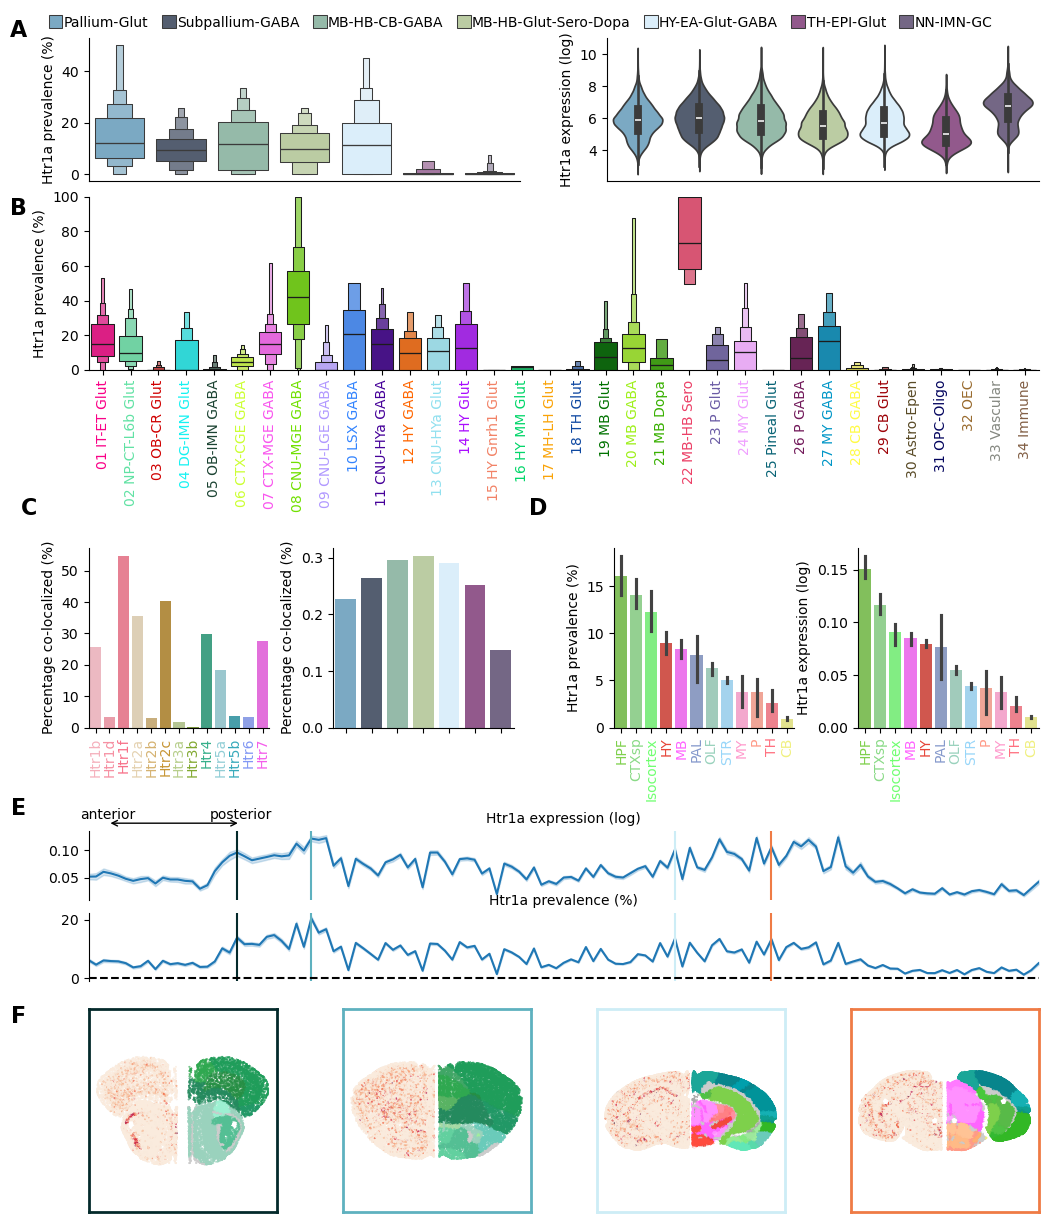

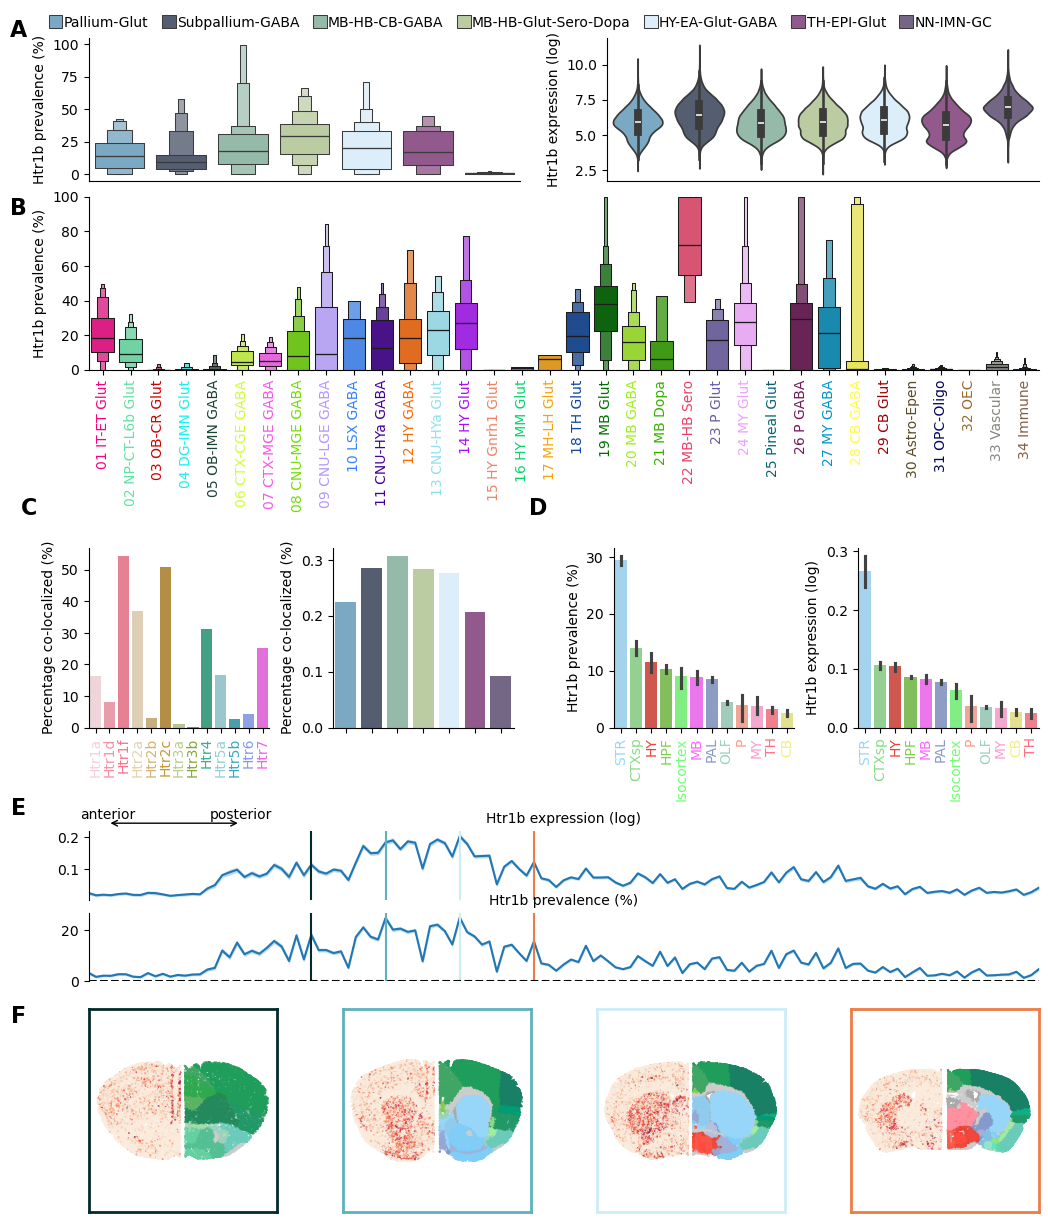

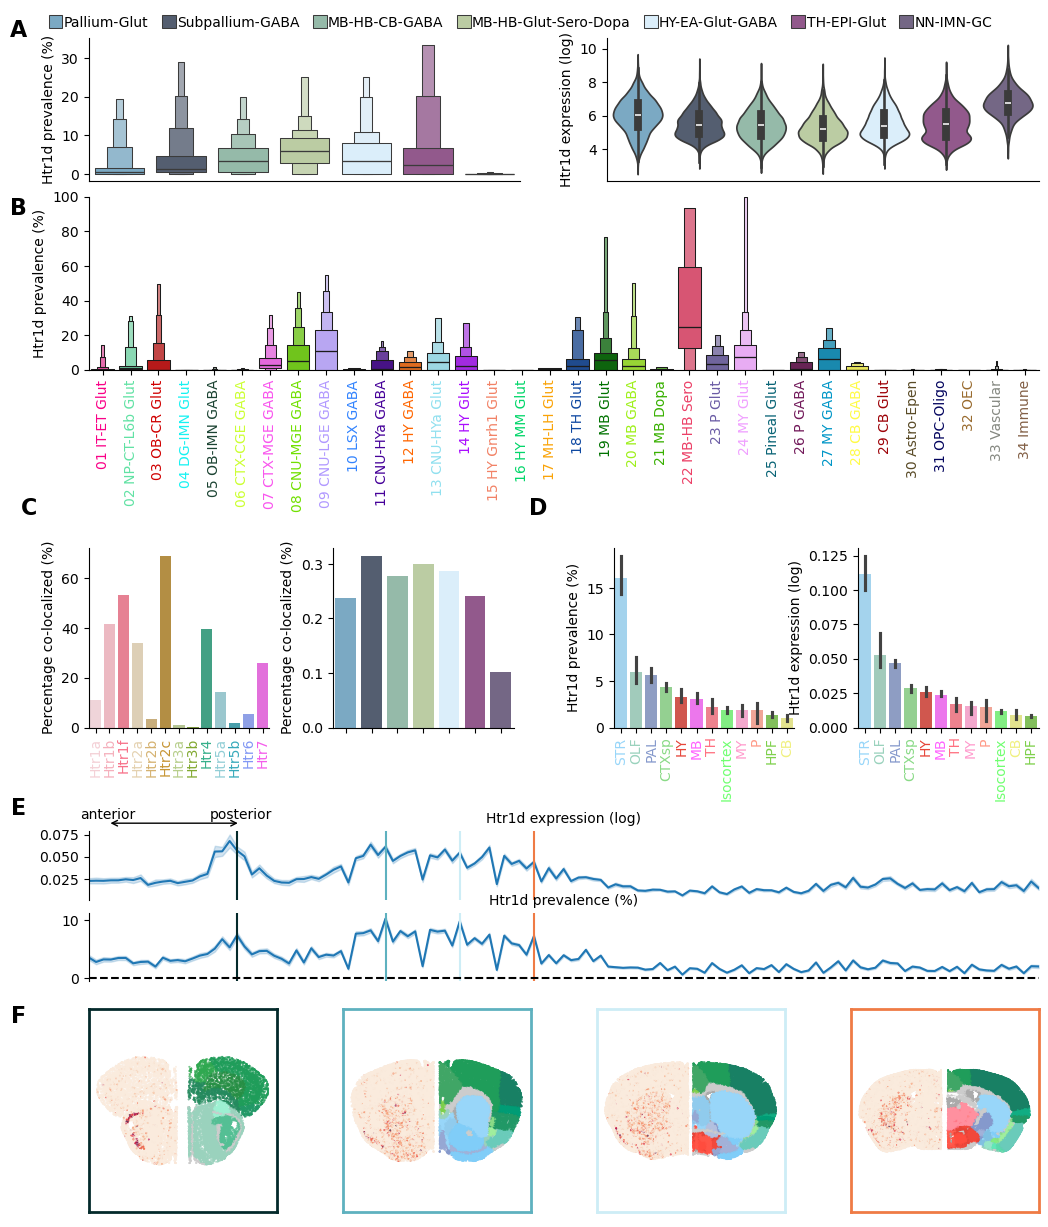

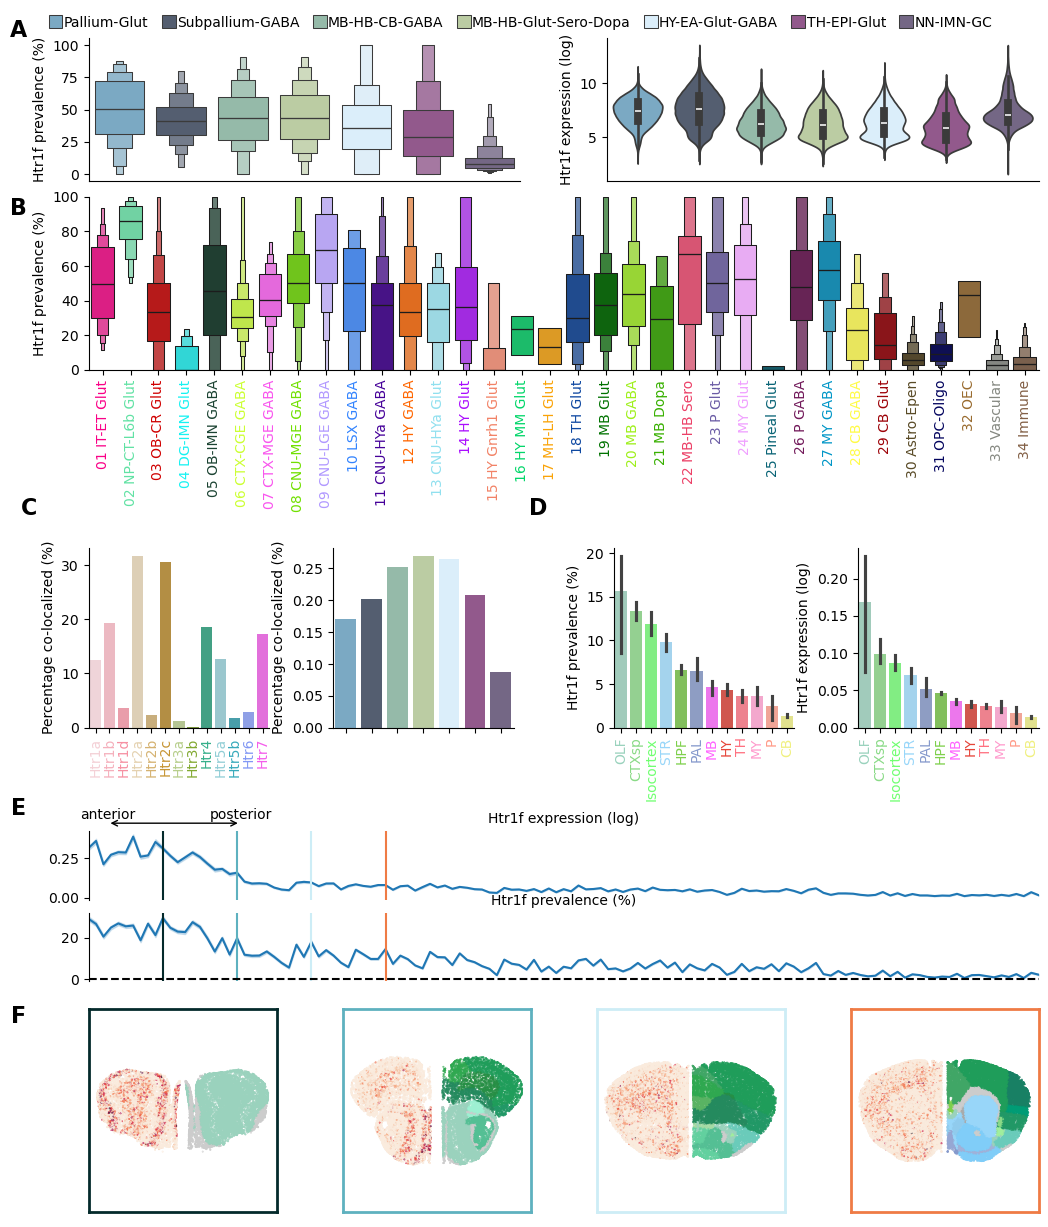

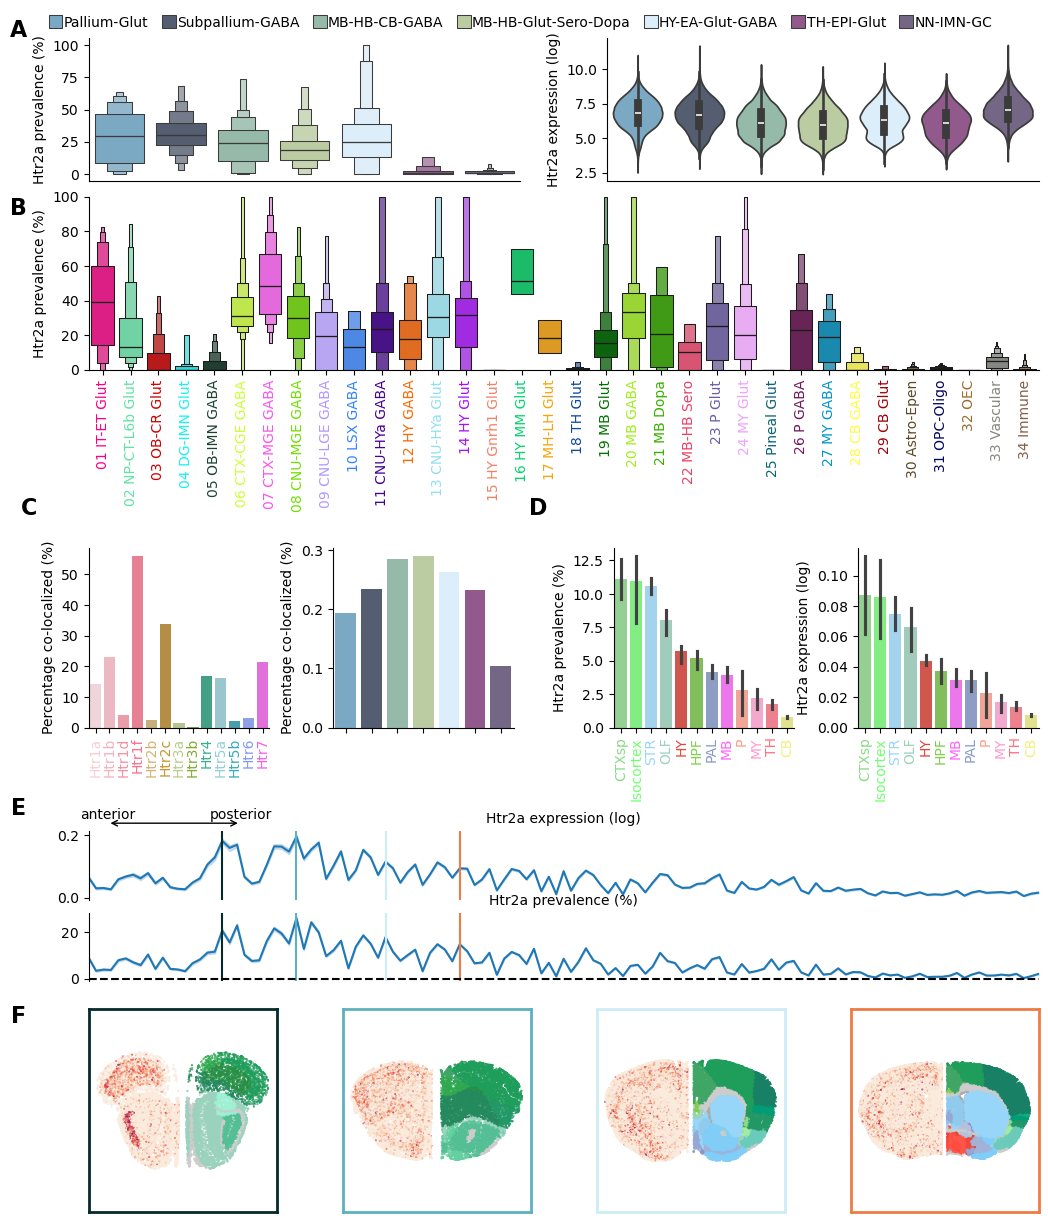

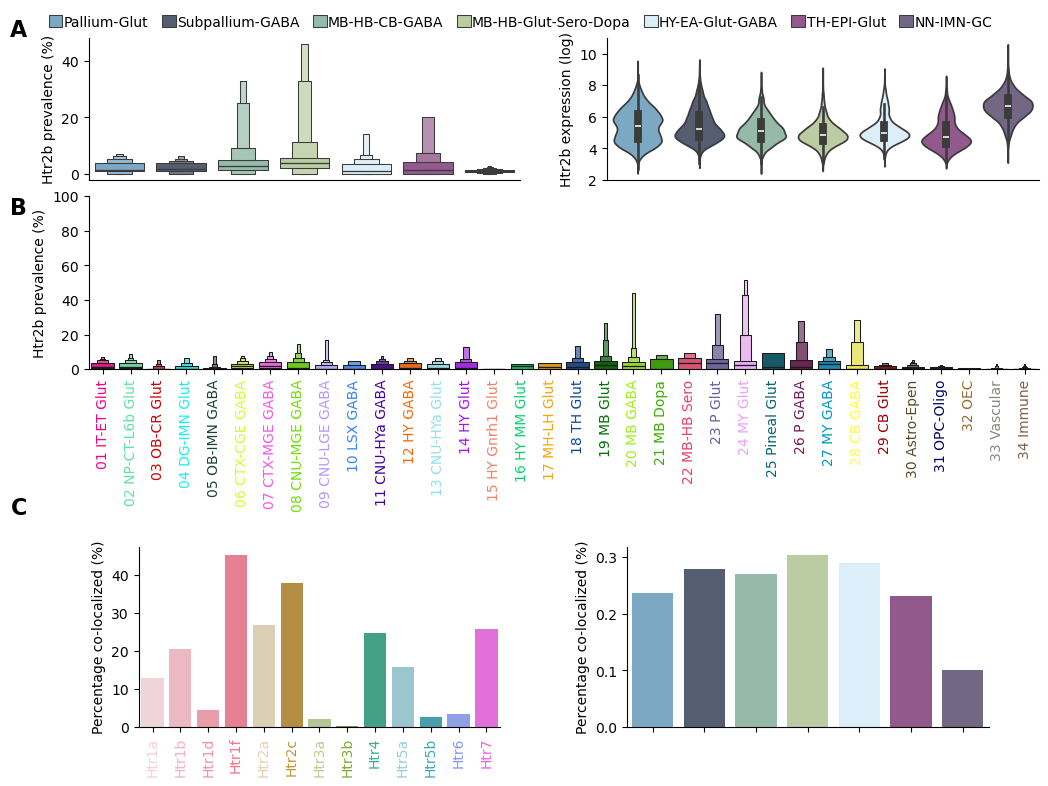

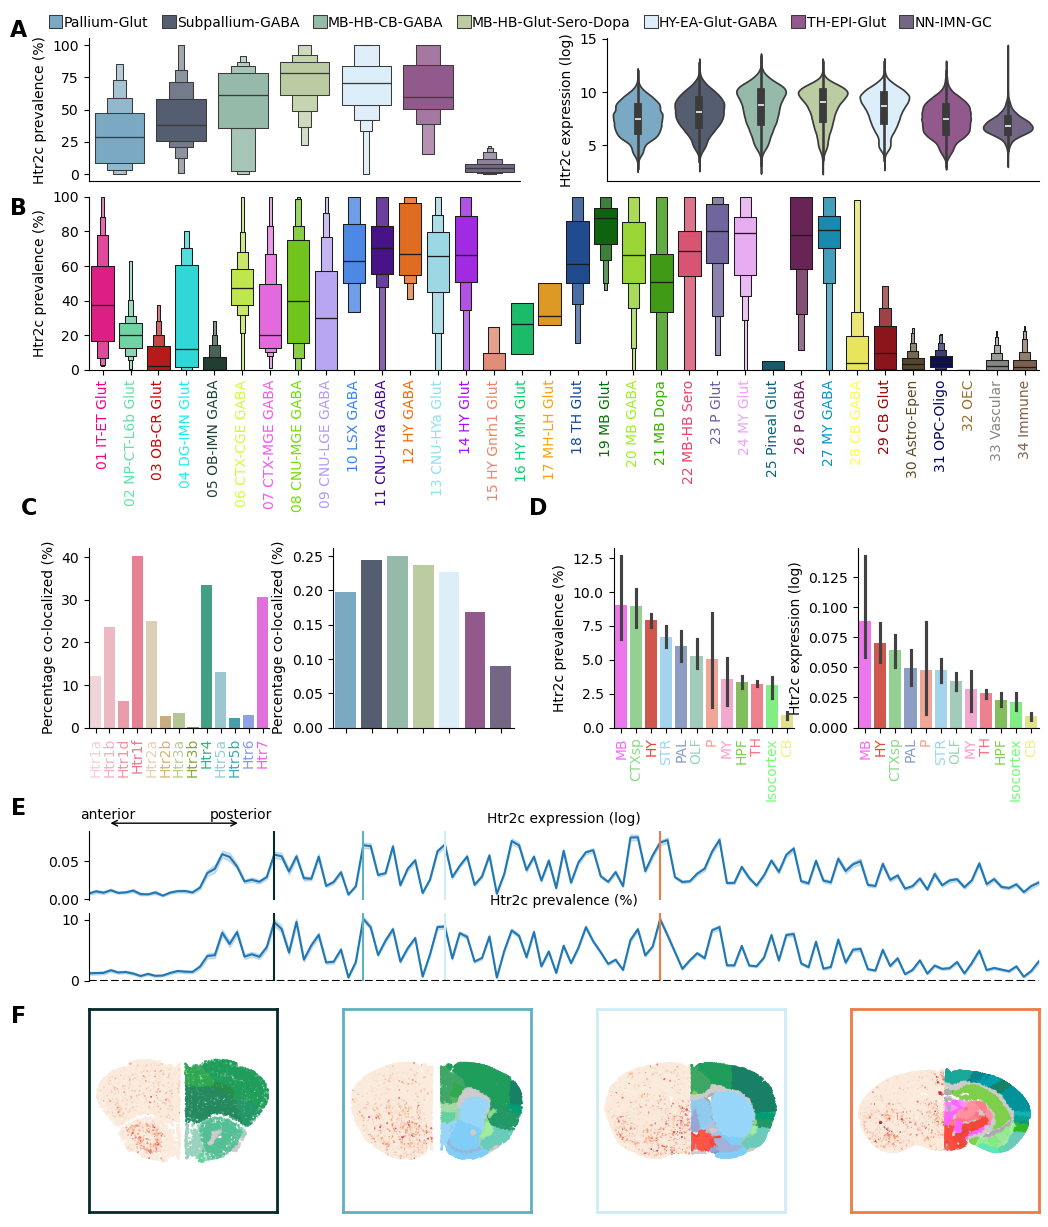

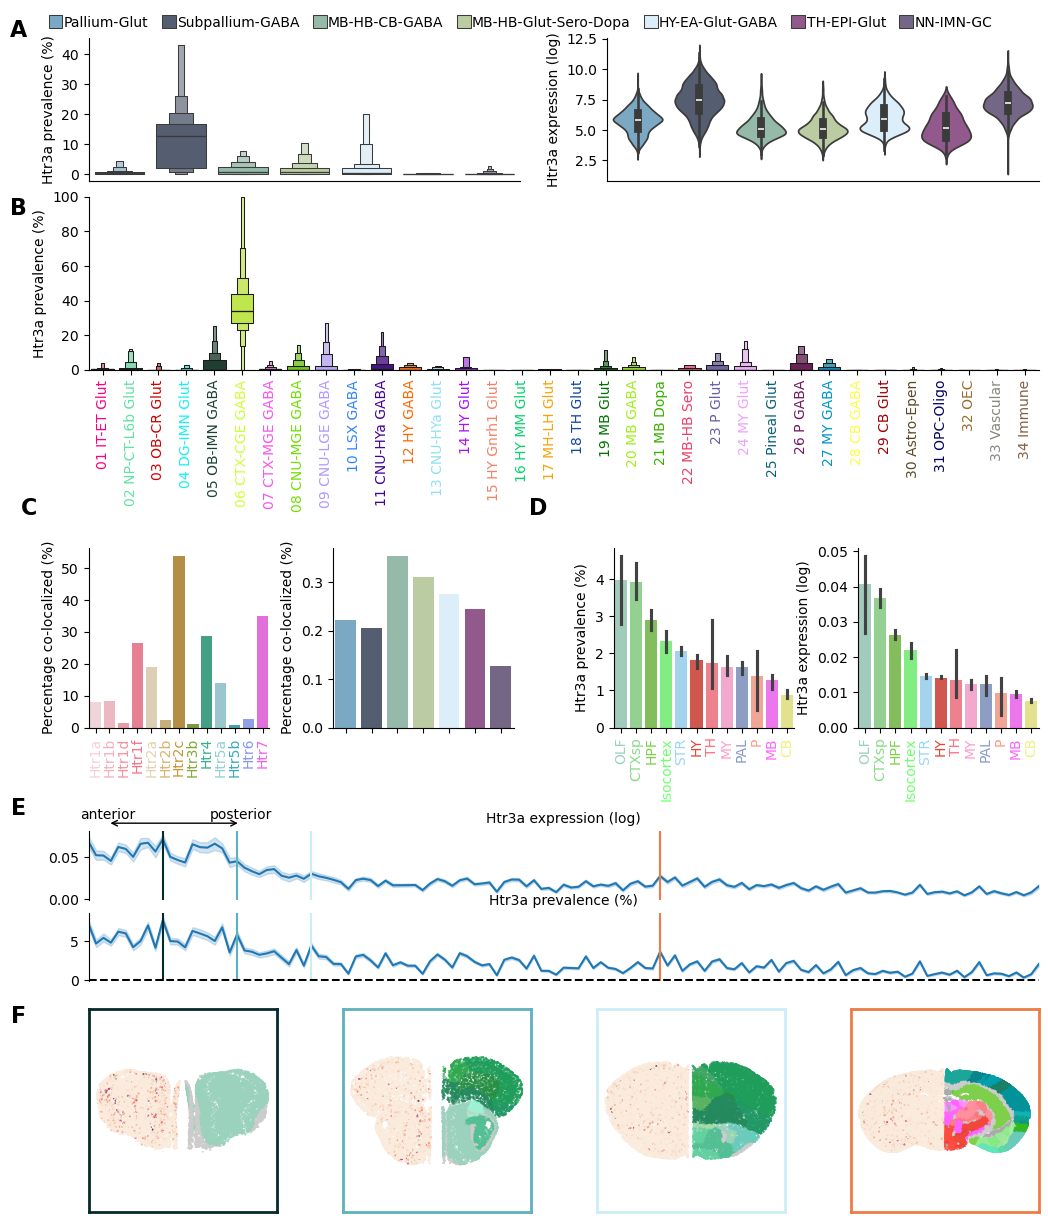

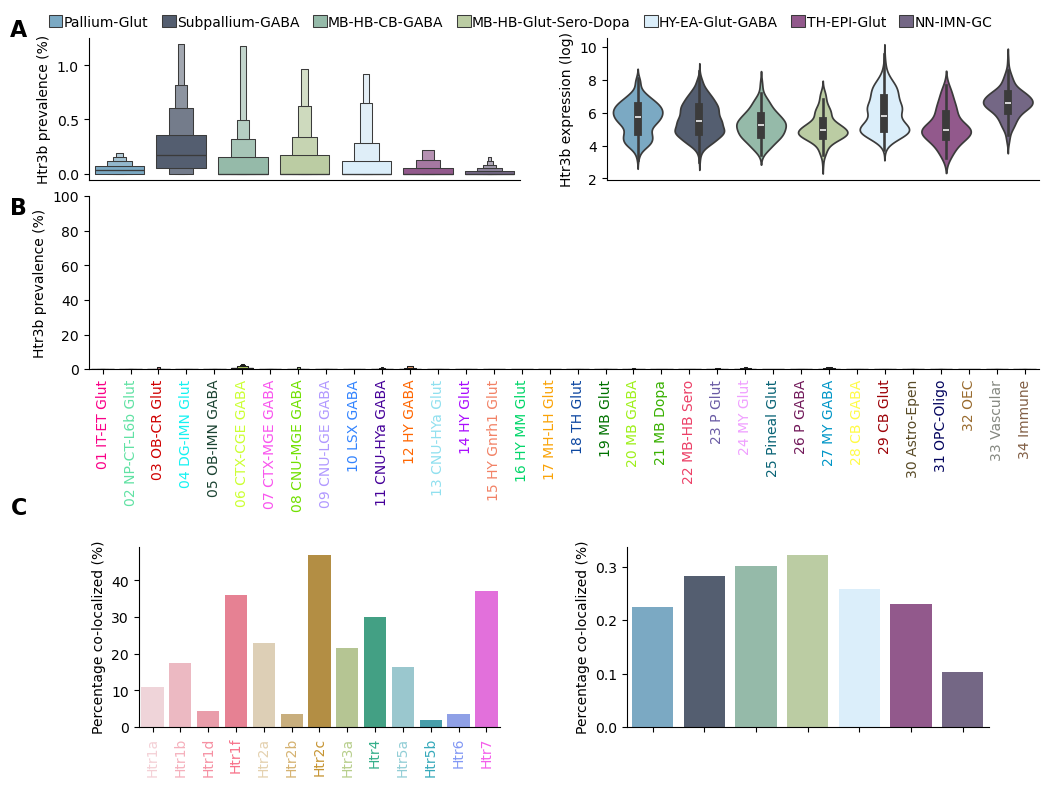

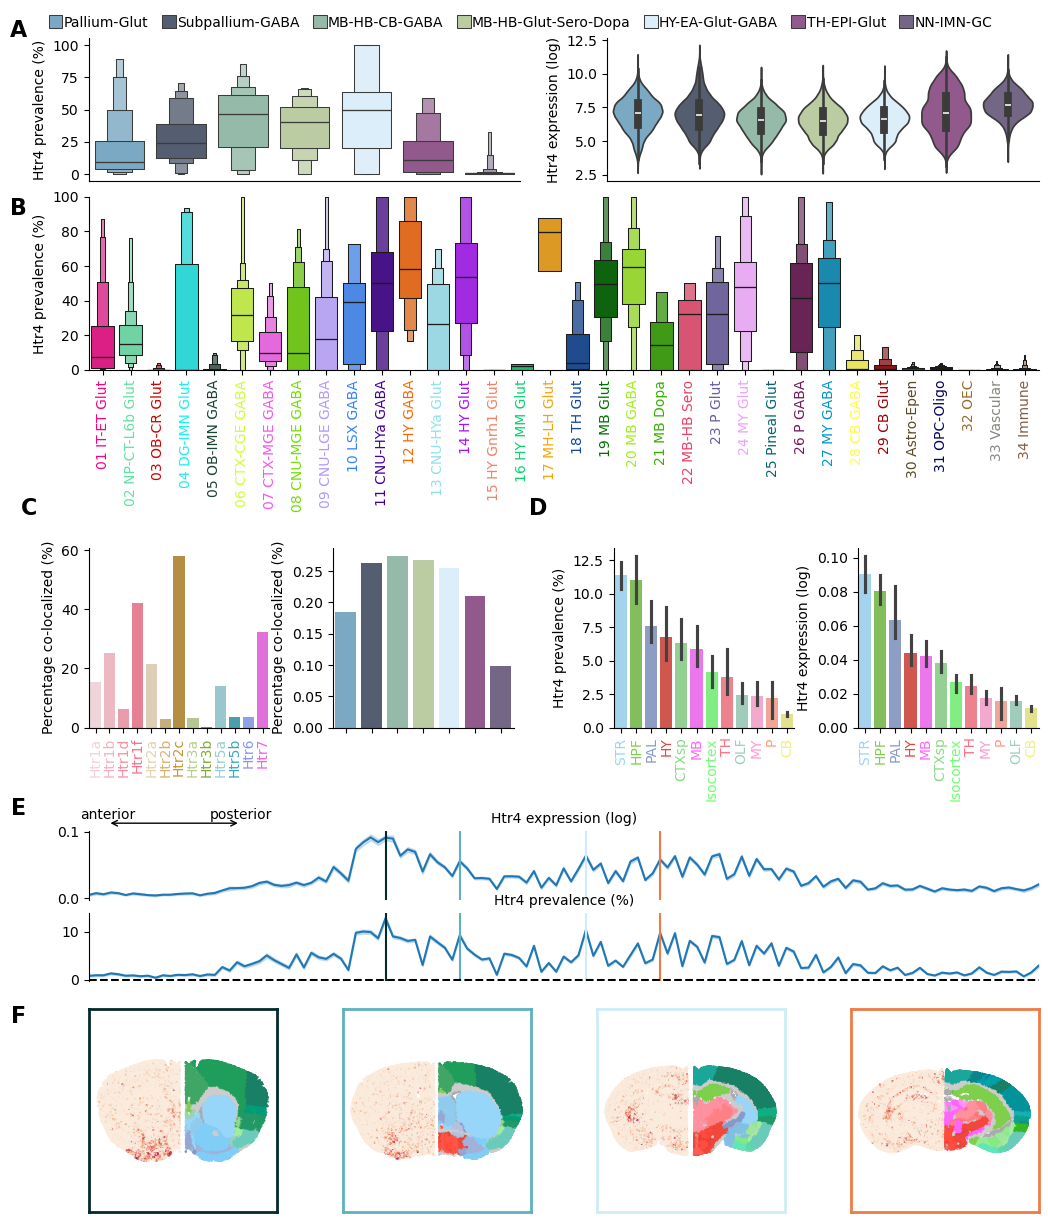

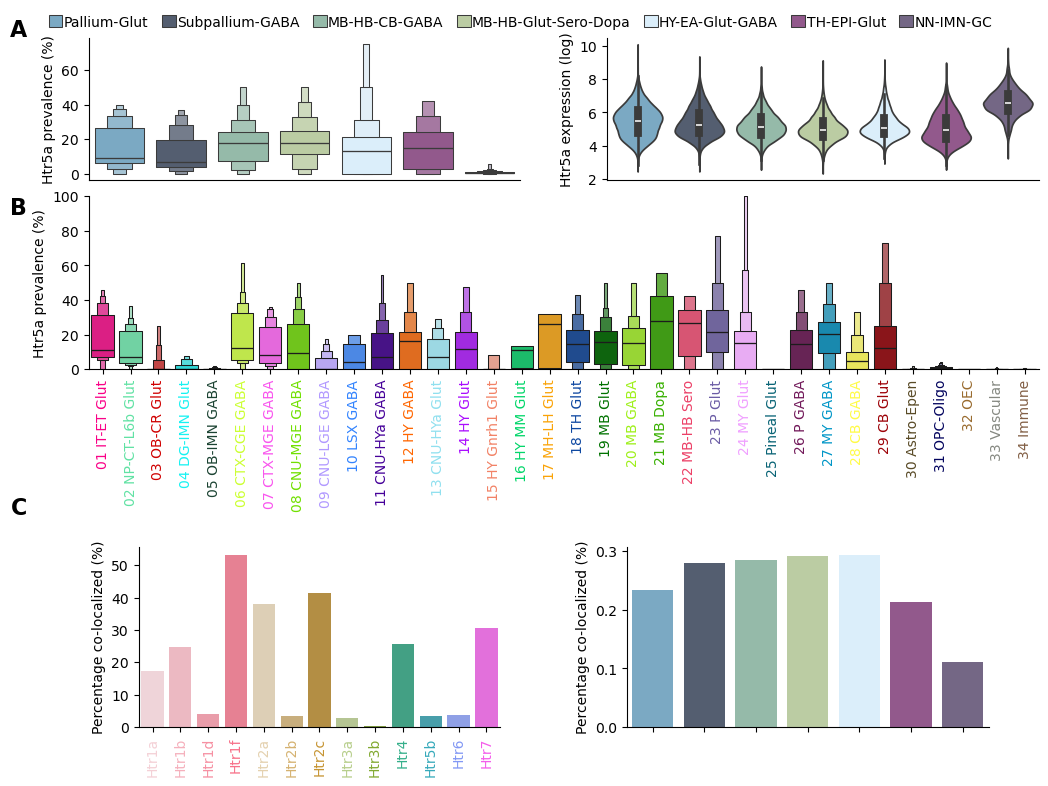

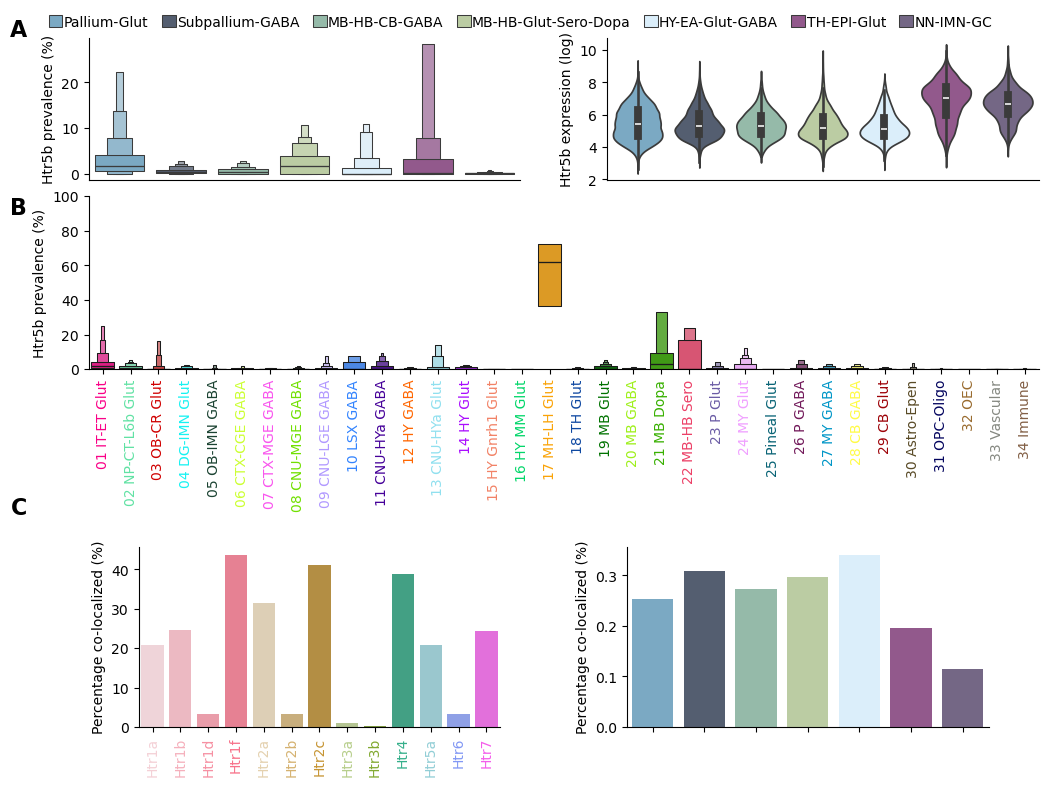

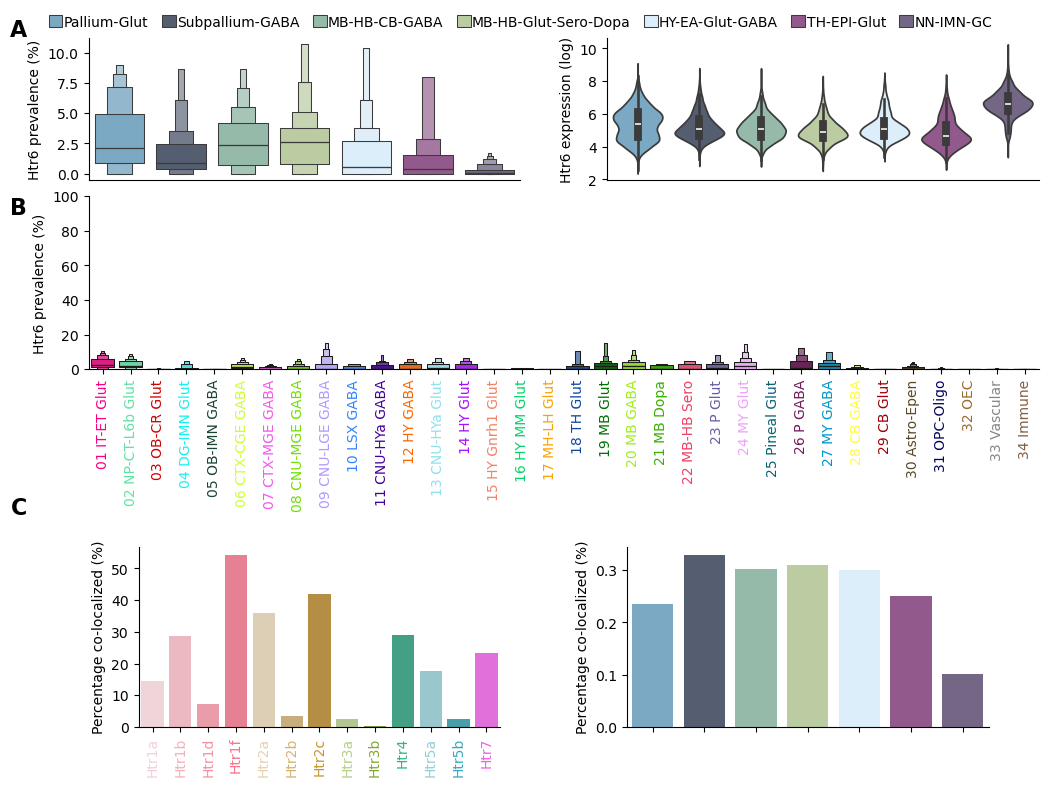

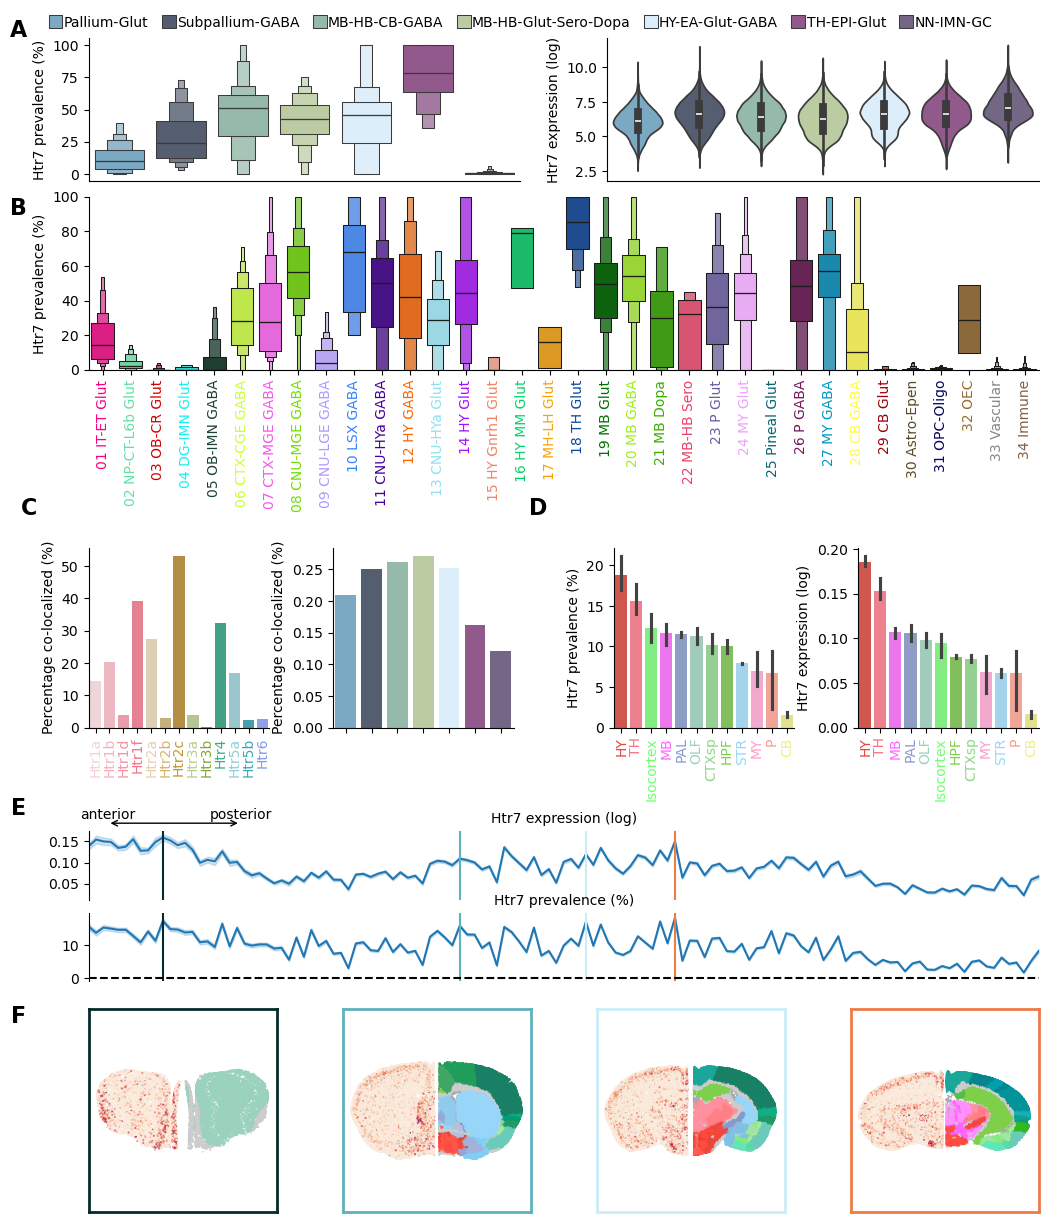

In [167]:
htrgenes =  exp.columns.sort_values()
for n,gene in tqdm(enumerate(htrgenes)):
    print(gene, n)
    fig = plot_figure(gene)
    fig.savefig(Path(output_folder, f'Figure_{n+2}.png'), bbox_inches='tight', dpi=300)

## supp

In [ ]:
coloc = pd.read_pickle(f"{output_folder_calculations}/cluster_group_colocalization.pkl")
coloc.rename(columns={"Value":"Co-localization"}, inplace=True)

In [ ]:

for n,gene in tqdm(enumerate(htrgenes)):
    coloc = coloc[coloc["Gene1"]==gene]
    coloc = coloc.groupby(["group", "Gene2"])["Co-localization"].mean().reset_index()
    
    grid = sns.FacetGrid(coloc, col="group", col_order=neuron_cluster_groups_order,
                         col_wrap=7, height=4)
    grid.map(sns.barplot, "Co-localization", "Gene2", "Gene2", order=htrgenes, hue_order=htrgenes, palette=htr_cmap )
    for ax in grid.axes.flat:
        ax.set_xlabel(f'Percentage expressing {gene} (%)')
    
        for ytick in ax.get_yticklabels():
            ytick.set_color(htr_cmap[ytick.get_text()])

# SST vs 5-HT2A

In [125]:
data_merfish.columns

Index(['brain_section_label', 'feature_matrix_label', 'donor_label',
       'donor_genotype', 'donor_sex', 'cluster_alias', 'x', 'y', 'z',
       'subclass_confidence_score', 'cluster_confidence_score',
       'high_quality_transfer', 'neurotransmitter', 'class', 'subclass',
       'supertype', 'cluster', 'neurotransmitter_color', 'class_color',
       'subclass_color', 'supertype_color', 'cluster_color', 'Htr7', 'Htr1f',
       'Htr1d', 'Htr4', 'Htr1b', 'Htr2a', 'Htr1a', 'Htr2c', 'Htr3a', 'x_ccf',
       'y_ccf', 'z_ccf', 'parcellation_index', 'parcellation_organ',
       'parcellation_category', 'parcellation_division',
       'parcellation_structure', 'parcellation_substructure',
       'parcellation_organ_color', 'parcellation_category_color',
       'parcellation_division_color', 'parcellation_structure_color',
       'parcellation_substructure_color'],
      dtype='object')

In [123]:
gene = "Htr2a"
data = joined_with_membership[(joined_with_membership["cluster_group_name"]!="WholeBrain")].reset_index(drop=True)

<AxesSubplot:xlabel='cluster'>

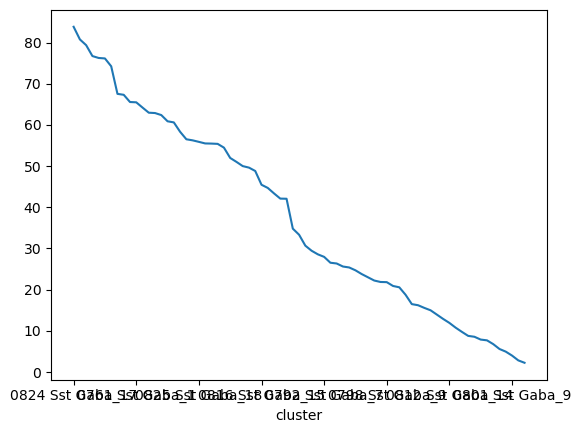

In [210]:
data[data['subclass']=='053 Sst Gaba'].groupby("cluster")['Htr2a'].apply(percentage_non_zero).sort_values(ascending=False).plot()

In [189]:
data[data['subclass']=='053 Sst Gaba'].groupby("cluster")['Htr2a'].apply(percentage_non_zero).sort_values(ascending=False)

cluster
0824 Sst Gaba_17    83.823529
0823 Sst Gaba_17    80.755396
0759 Sst Gaba_1     79.358717
0758 Sst Gaba_1     76.715040
0828 Sst Gaba_19    76.250000
                      ...    
0780 Sst Gaba_4      5.591825
0770 Sst Gaba_3      4.950495
0801 Sst Gaba_9      3.996101
0779 Sst Gaba_4      2.827415
0778 Sst Gaba_4      2.242991
Name: Htr2a, Length: 73, dtype: float64

In [ ]:
n = 0  # Replace with your actual value for 'n'

# Find the cluster of interest
cluster_of_interest = data[data['subclass']=='053 Sst Gaba'].groupby("cluster")['Htr2a'].apply(percentage_non_zero).sort_values(ascending=False).index[n]


data_per_clu = data_merfish[data_merfish["cluster"]==cluster_of_interest]


# Filtering the DataFrame
filtered_data = data_per_clu[data_per_clu['parcellation_category'] == "grey"]

# Counting the occurrences
structure_counts = filtered_data['parcellation_structure'].value_counts()

# Extracting colors in the order of the structures
colors = [color_dict.get(structure, 'default_color') for structure in structure_counts.index]

# Plotting the bar chart with the specified colors
plt.figure(figsize=(10, 6))
structure_counts.plot.bar(color=colors)
#plt.title(f"Cluster {cluster_of_interest},prevalence htr2a {round(data[data['subclass']=='053 Sst Gaba'].groupby("cluster")['Htr2a'].apply(percentage_non_zero).sort_values(ascending=False).loc[cluster_of_interest], 3)}%")
plt.xlabel("Region of Interest")
plt.ylabel("Count")

  0%|          | 0/10 [00:00<?, ?it/s]

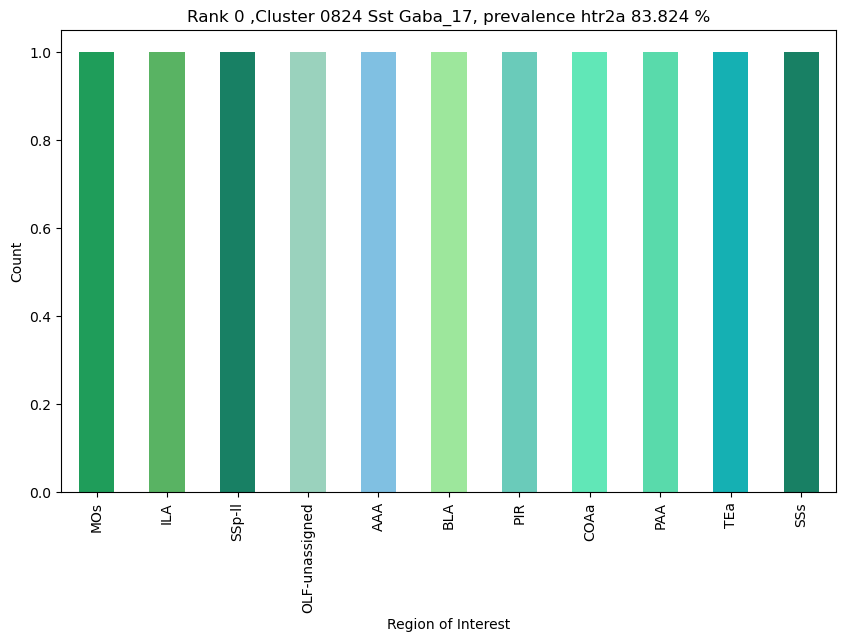

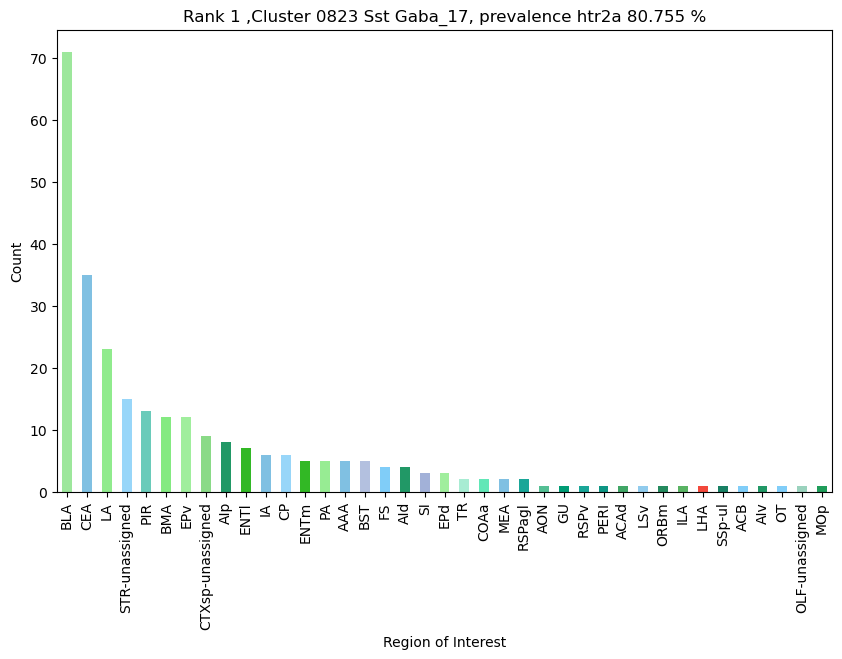

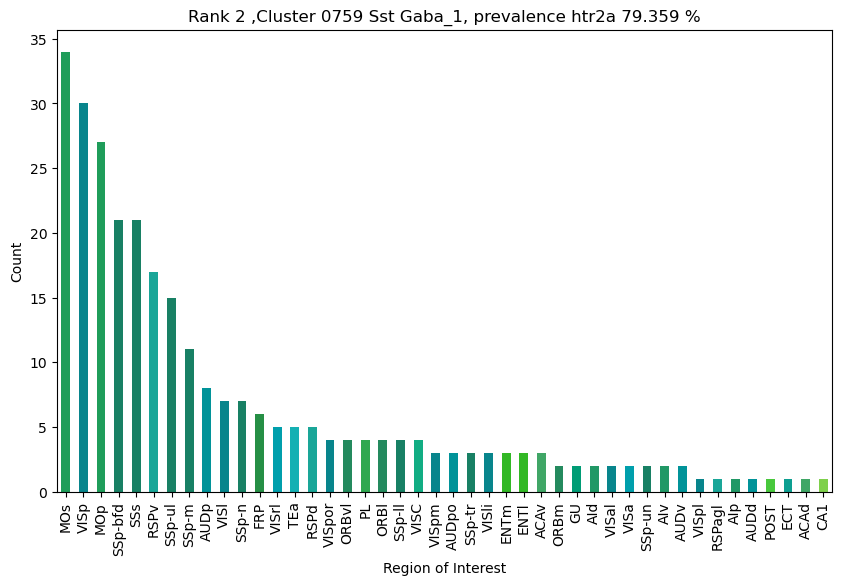

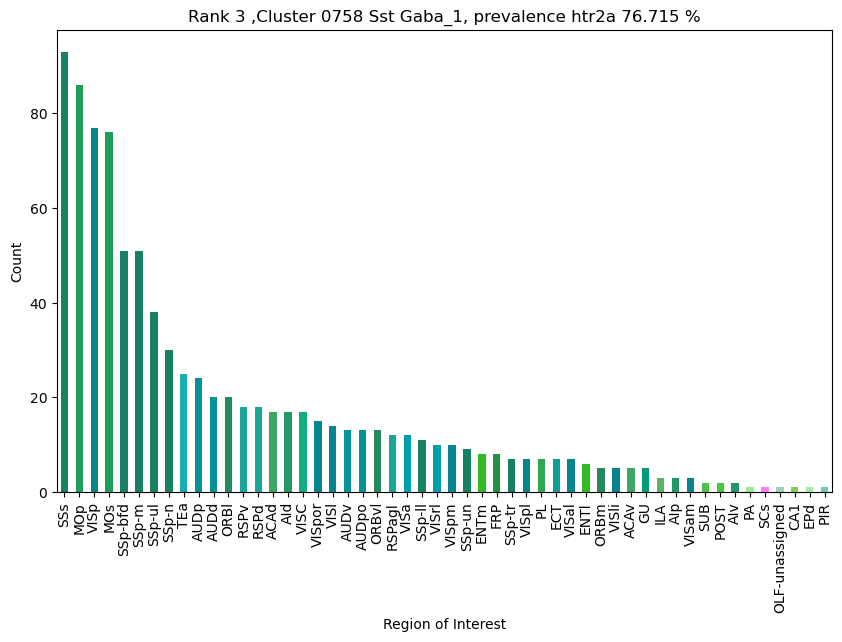

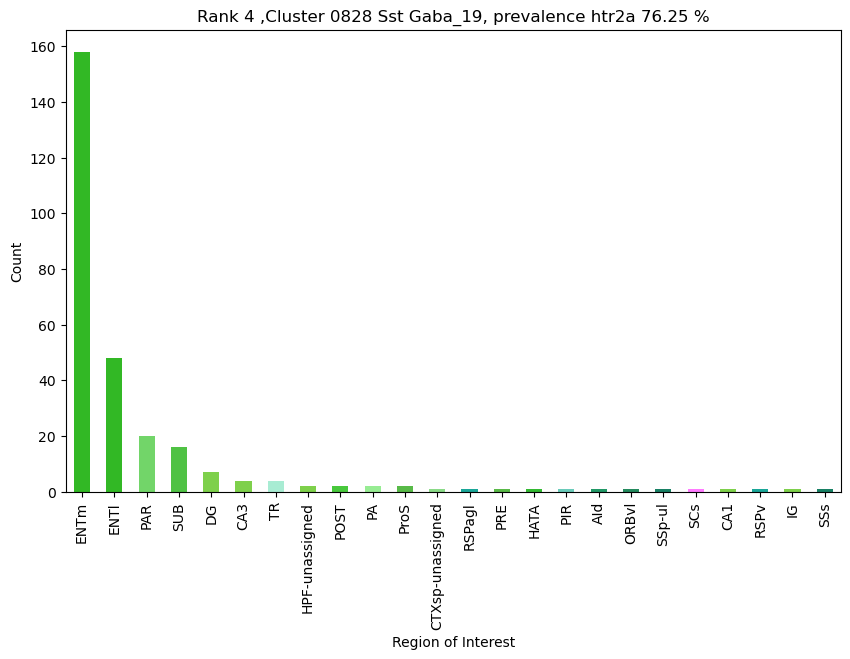

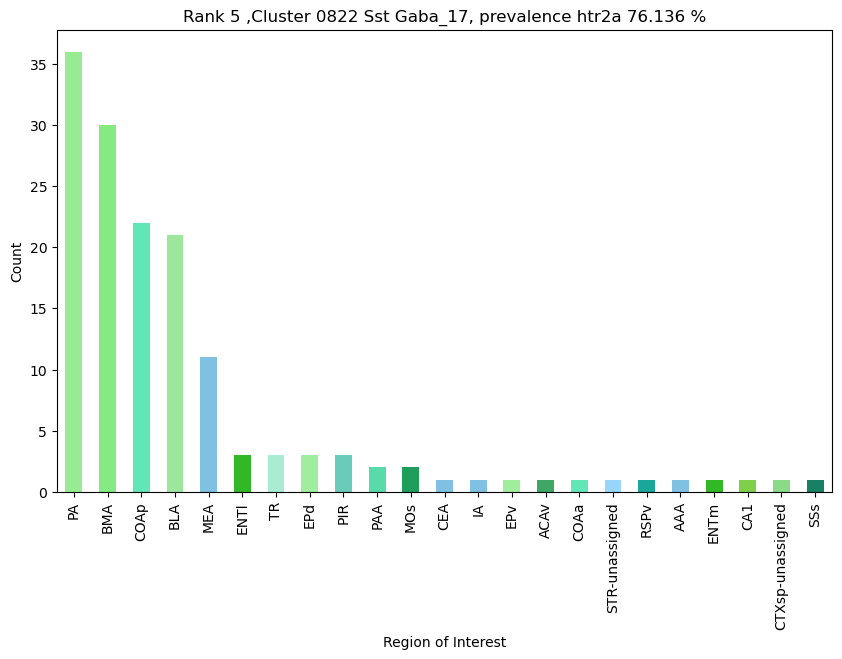

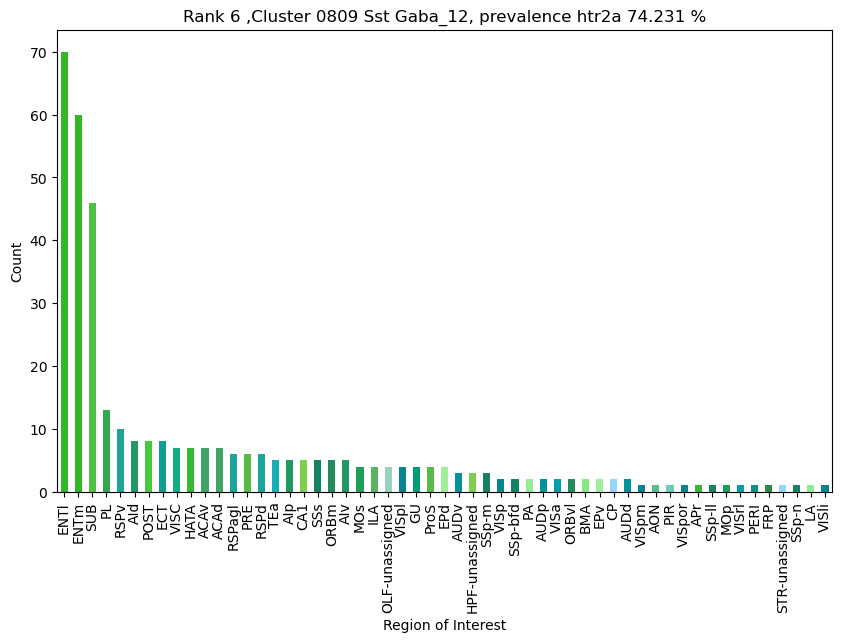

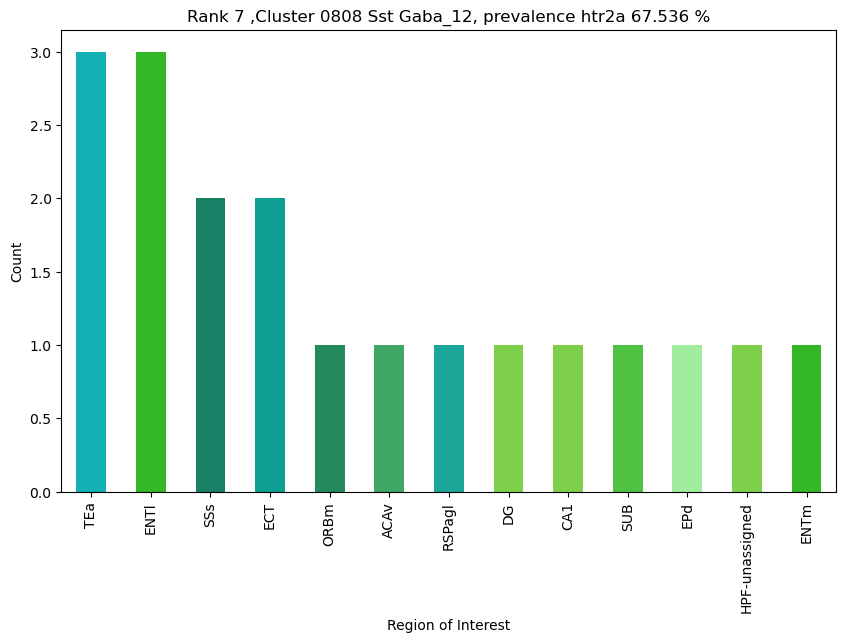

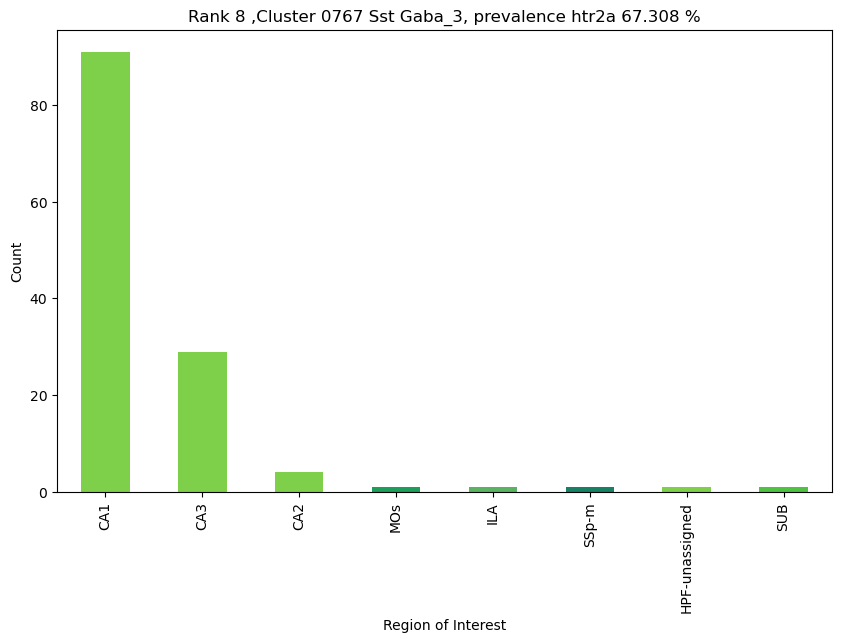

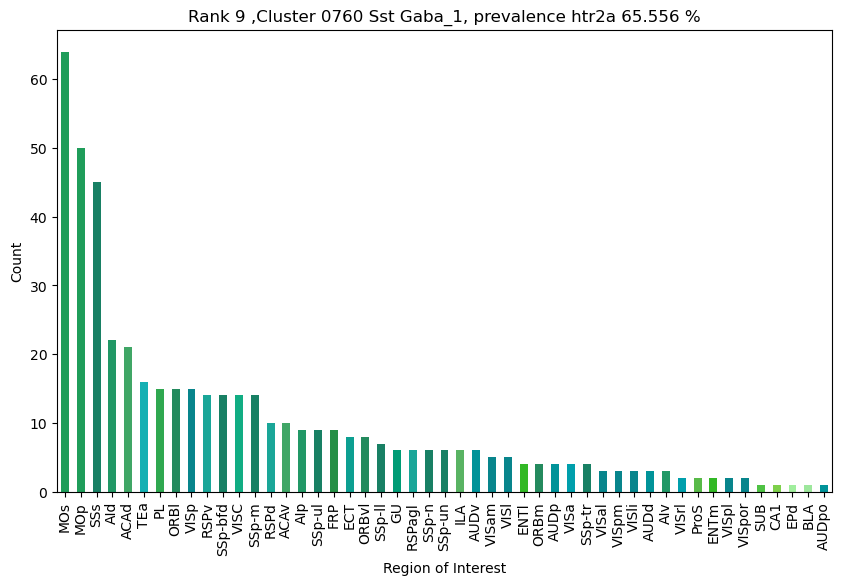

In [212]:
_ = data[data['subclass']=='053 Sst Gaba'].groupby("cluster")['Htr2a'].apply(percentage_non_zero).sort_values(ascending=False)
for n in tqdm(range(10)):

    # Find the cluster of interest
    cluster_of_interest = _.index[n]
    
    
    data_per_clu = data_merfish[data_merfish["cluster"]==cluster_of_interest]
    
    
    # Filtering the DataFrame
    filtered_data = data_per_clu[data_per_clu['parcellation_category'] == "grey"]
    
    # Counting the occurrences
    structure_counts = filtered_data['parcellation_structure'].value_counts()
    
    # Extracting colors in the order of the structures
    colors = [color_dict.get(structure, 'default_color') for structure in structure_counts.index]
    
    # Plotting the bar chart with the specified colors
    plt.figure(figsize=(10, 6))
    structure_counts.plot.bar(color=colors)
    plt.title(f"Rank {n} ,Cluster {cluster_of_interest}, prevalence htr2a {round(_.loc[cluster_of_interest], 3)} %")
    plt.xlabel("Region of Interest")
    plt.ylabel("Count")

In [206]:
data[data['subclass']=='053 Sst Gaba'].groupby("cluster")['Htr2a'].apply(percentage_non_zero).sort_values(ascending=False)

cluster
0824 Sst Gaba_17    83.823529
0823 Sst Gaba_17    80.755396
0759 Sst Gaba_1     79.358717
0758 Sst Gaba_1     76.715040
0828 Sst Gaba_19    76.250000
                      ...    
0780 Sst Gaba_4      5.591825
0770 Sst Gaba_3      4.950495
0801 Sst Gaba_9      3.996101
0779 Sst Gaba_4      2.827415
0778 Sst Gaba_4      2.242991
Name: Htr2a, Length: 73, dtype: float64